### 분석준비

In [ ]:
# 필요 라이브러리

# 분석을 위한 라이브러리
import numpy as np
import pandas as pd

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os

# 에러메세지 안나오게
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)

#워드클라우드
from wordcloud import WordCloud 
from PIL import *

In [11]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [3]:
# 디비 연결
def rds_python_conn():
    import psycopg2
    import json
    from sqlalchemy import create_engine
    # rds와 python 연동을 위한 정보 입력
    with open('postgres.info.json','r') as json_file:
        db_info = json.load(json_file)

    host = "postgres.c4brhfvhrm5g.ap-northeast-2.rds.amazonaws.com"
    dbname = 'postgres' 
    user = 'postgres' 
    password = "postgres123"
    port = 5432

    connection = psycopg2.connect(host=host,
                                  dbname=dbname ,
                                  user=user ,
                                  password=password ,
                                  port=port)
    return connection

def sql(SQL):
    connection = rds_python_conn()
    cur = connection.cursor()

    cur.execute(SQL)
    rows = cur.fetchall()
    return rows


### 판매자 전환율 = 체결된 잠재고객수/전체잠재고객수

In [7]:
SQL = """
SELECT *
FROM mql m full outer join closed_deals j on m.mql_id=j.mql_id
;
"""
mql = pd.read_sql(SQL, rds_python_conn())
mql

,mql_id,first_contact_date,landing_page_id,origin,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue
0,5143,2018-02-01,490,social,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
1,5819,2017-10-20,247,paid_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
2,1369,2018-03-22,95,organic_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
3,312,2018-01-22,435,email,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
4,3690,2018-02-21,119,organic_search,3690.0,2187.0,17.0,2.0,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2920,2018-05-22,300,paid_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
7996,3895,2018-03-27,269,paid_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
7997,7527,2017-08-27,119,organic_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN
7998,639,2017-10-06,489,organic_search,NaN,NaN,NaN,NaN,NaT,None,None,None,None,NaN


In [8]:
mql['won_date_new'] = pd.to_datetime(mql['won_date']).dt.strftime('%Y-%m')
mql['first_contact_date_new'] = pd.to_datetime(mql['first_contact_date']).dt.strftime('%Y-%m')

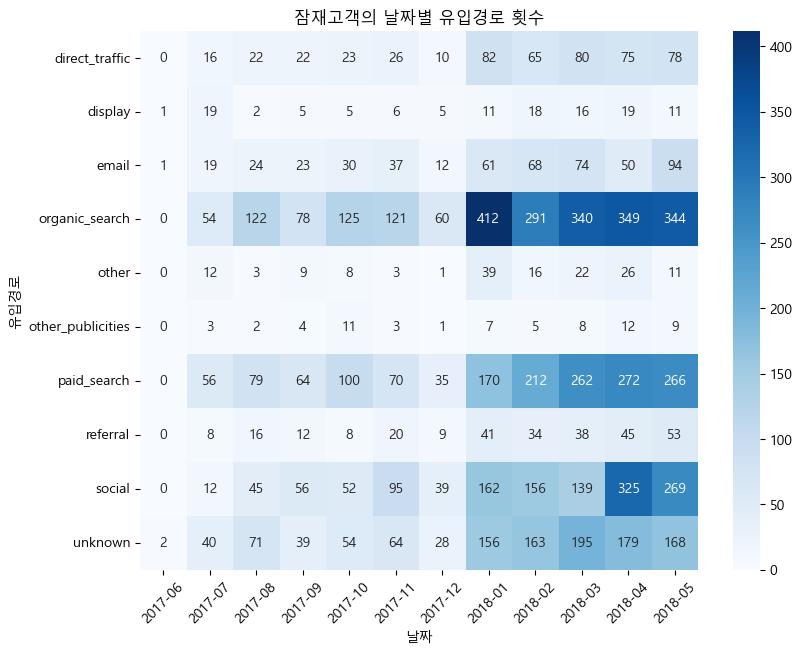

In [9]:
q1 = pd.pivot_table(mql,
                   index='origin',
                   columns=pd.to_datetime(mql['first_contact_date']).dt.strftime('%Y-%m'),
                   values='landing_page_id',                            
                   aggfunc='count',
                   fill_value=0)

# 그래프 크기 조정
plt.figure(figsize=(9, 7))

# Heatmap 그리기
sns.heatmap(q1, annot=True, fmt='d', cmap='Blues')

# 그래프 타이틀 설정
plt.title('잠재고객의 날짜별 유입경로 횟수')

# x축과 y축 레이블 설정
plt.xlabel('날짜')
plt.ylabel('유입경로')
plt.xticks(rotation=45)

# 폰트 크기 설정
sns.set(font_scale=1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '2017-12'),
  Text(1.5, 0, '2018-01'),
  Text(2.5, 0, '2018-02'),
  Text(3.5, 0, '2018-03'),
  Text(4.5, 0, '2018-04'),
  Text(5.5, 0, '2018-05'),
  Text(6.5, 0, '2018-06'),
  Text(7.5, 0, '2018-07'),
  Text(8.5, 0, '2018-08'),
  Text(9.5, 0, '2018-09'),
  Text(10.5, 0, '2018-10'),
  Text(11.5, 0, '2018-11')])

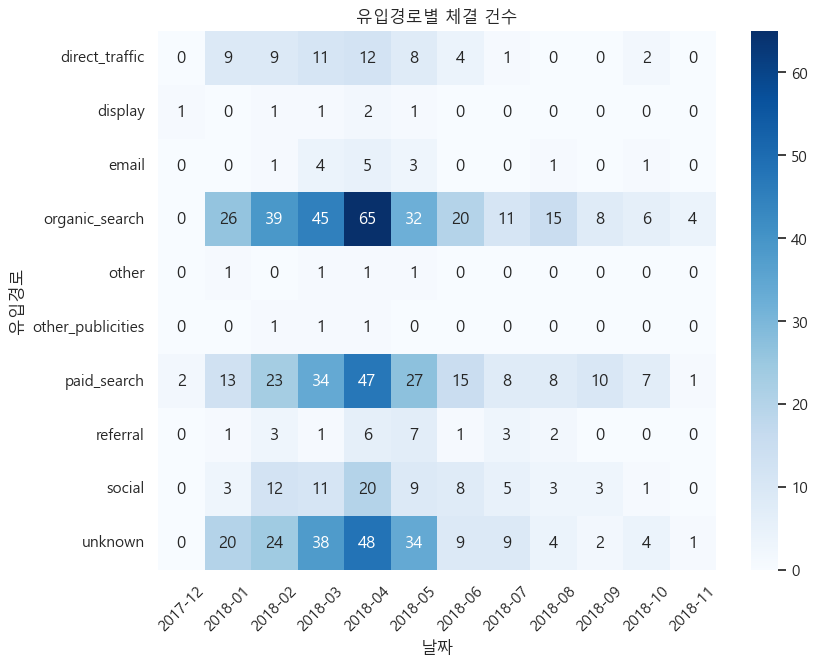

In [12]:
q1 = pd.pivot_table(mql,
                   index='origin',
                   columns='won_date_new',
                   values='seller_id',                            
                   aggfunc='count',
                   fill_value=0)

# 그래프 크기 조정
plt.figure(figsize=(9, 7))

# Heatmap 그리기
sns.heatmap(q1, annot=True, fmt='d', cmap='Blues')

# 그래프 타이틀 설정
plt.title('유입경로별 체결 건수')

# x축과 y축 레이블 설정
plt.xlabel('날짜')
plt.ylabel('유입경로')
plt.xticks(rotation=45)

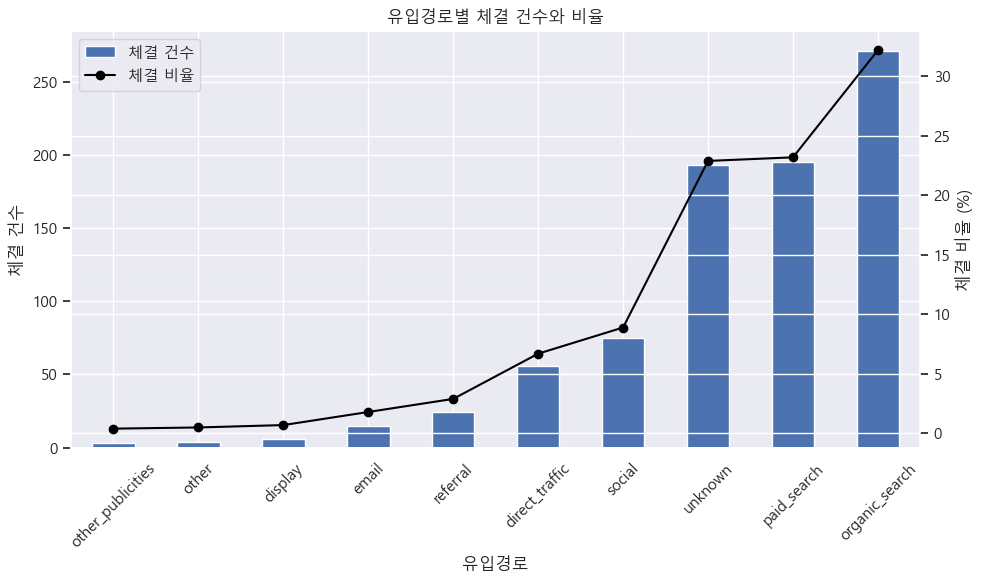

In [55]:
won_counts = mql.groupby('origin')['seller_id'].count().sort_values()
won_percentages = round(won_counts / won_counts.sum() * 100, 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 체결 건수 막대 그래프 그리기
bar_plot = won_counts.plot(kind='bar', label='체결 건수')  # label 속성 추가
plt.ylabel('체결 건수')
plt.xlabel('유입경로')
plt.xticks(rotation=45)

# 체결 비율 선 그래프 그리기
plt.twinx()  # 오른쪽 y축 사용
line_plot = won_percentages.plot(marker='o',color='black',label='체결 비율')  # label 속성 추가
plt.ylabel('체결 비율 (%)')

# 범례 추가
handles, labels = bar_plot.get_legend_handles_labels()
handles2, labels2 = line_plot.get_legend_handles_labels()
plt.legend(handles + handles2, labels + labels2)

plt.title('유입경로별 체결 건수와 비율')
# 그래프 보여주기
plt.tight_layout()
plt.show()



Text(0.5, 1.0, '비즈니스 타입별 매출')

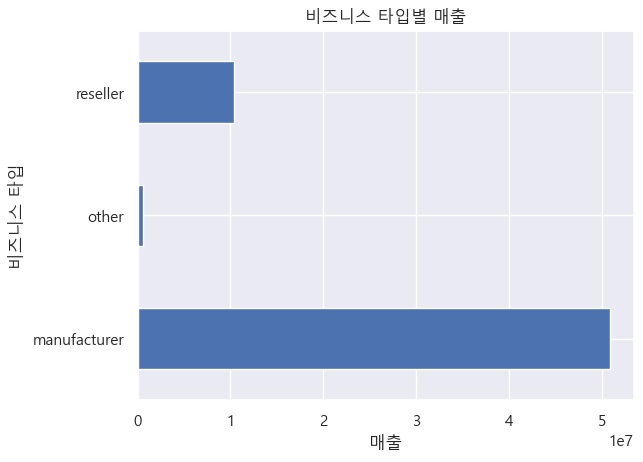

In [15]:
mql.groupby('business_type')['declared_monthly_revenue'].sum().plot(kind='barh')
plt.xlabel('매출')
plt.ylabel('비즈니스 타입')
plt.title('비즈니스 타입별 매출')

Text(0.5, 1.0, '비즈니스 타입별 판매자현황')

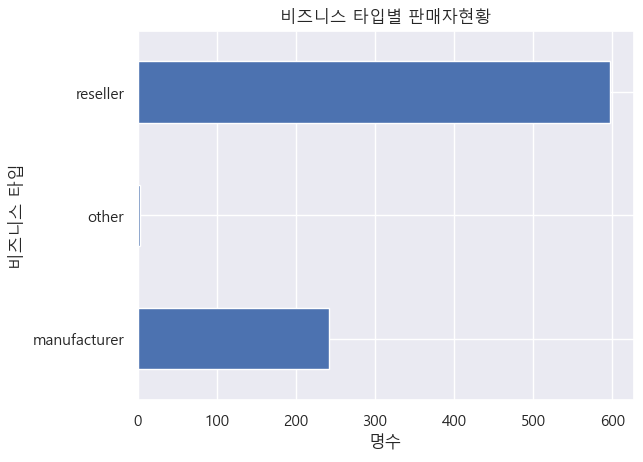

In [16]:
mql.groupby('business_type')['mql_id'].size().plot(kind='barh')
plt.xlabel('명수')
plt.ylabel('비즈니스 타입')
plt.title('비즈니스 타입별 판매자현황')

Text(0.5, 0, '비즈니스타입')

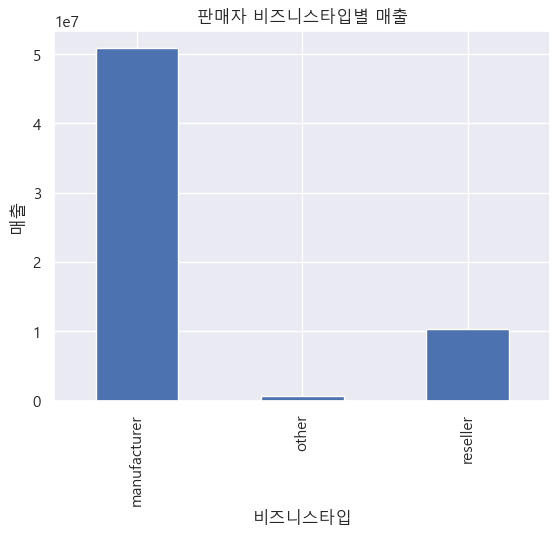

In [14]:
mql.groupby('business_type')['declared_monthly_revenue'].sum().plot(kind='bar')
plt.title('판매자 비즈니스타입별 매출')
plt.ylabel('매출')
plt.xlabel('비즈니스타입')

Text(0, 0.5, '비즈니스분야')

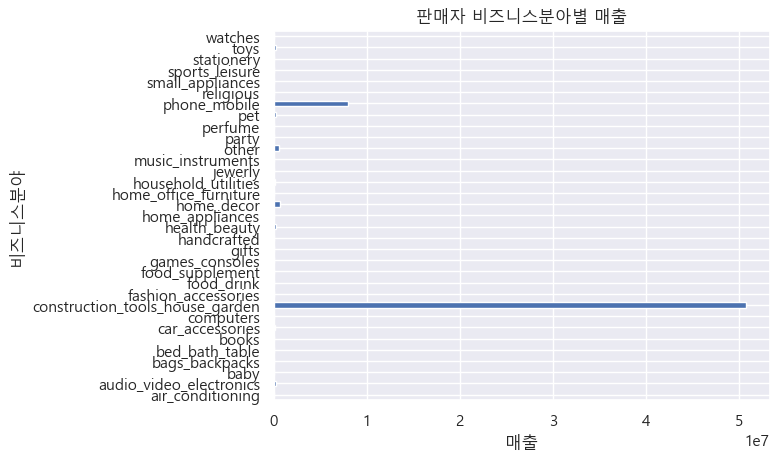

In [20]:
mql.groupby('business_segment')['declared_monthly_revenue'].sum().plot(kind='barh')
plt.title('판매자 비즈니스분아별 매출')
plt.xlabel('매출')
plt.ylabel('비즈니스분야')

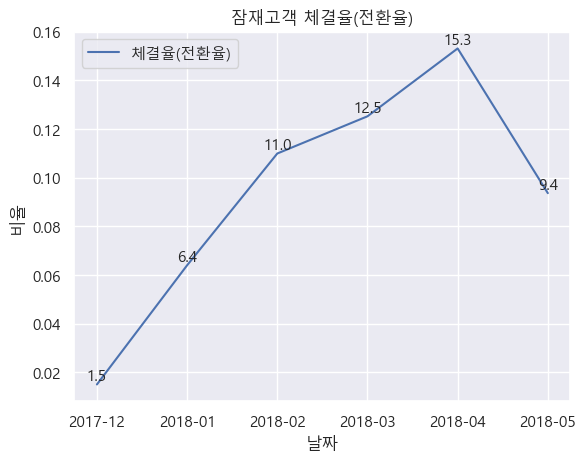

In [14]:
a=mql.groupby(pd.to_datetime(mql['won_date']).dt.strftime('%Y-%m'))['mql_id'].size().reset_index(name='체결된사람')
b=mql.groupby(pd.to_datetime(mql['first_contact_date']).dt.strftime('%Y-%m'))['mql_id'].size().reset_index(name='컨택한 사람')
ab = a.merge(b,left_on='won_date',right_on='first_contact_date',how='outer').fillna(0)
ab['ratio'] = ab['체결된사람'] / ab['컨택한 사람']
ab[0:6].plot(x='first_contact_date', y='ratio', label='체결율(전환율)')
plt.title('잠재고객 체결율(전환율)')
plt.ylabel('비율')
plt.xlabel('날짜')
for i, v in enumerate(ab[0:6]['ratio']):
    plt.text(i, v, round(v*100,1), ha='center', va='bottom', fontsize=11)

Text(0, 0.5, '성향')

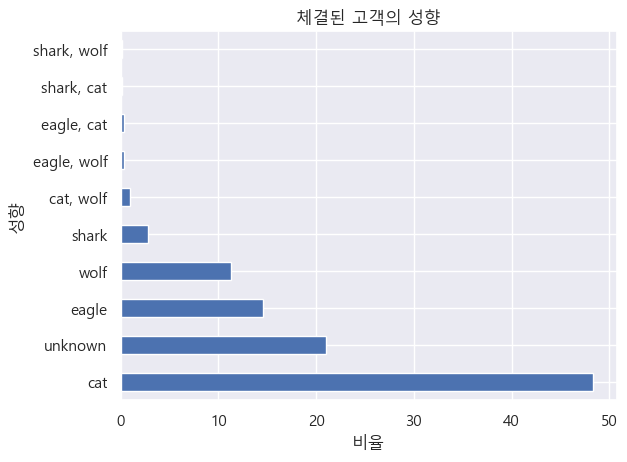

In [120]:
(mql.lead_behaviour_profile.value_counts(normalize=True)*100).plot(kind='barh')
plt.title('체결된 고객의 성향')
plt.xlabel('비율')
plt.ylabel('성향')

Text(0, 0.5, '비즈니스 분야')

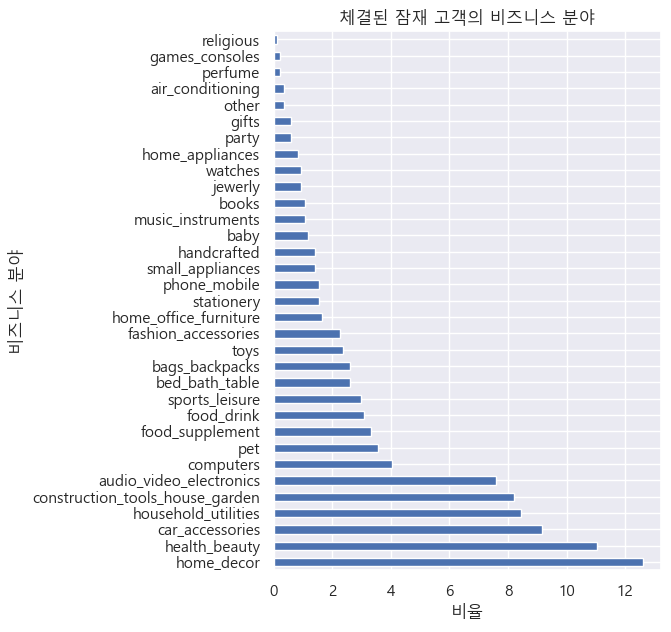

In [126]:
(mql.business_segment.value_counts(normalize=True)*100).plot(kind='barh', figsize=(5,7))
plt.title('체결된 잠재 고객의 비즈니스 분야')
plt.xlabel('비율')
plt.ylabel('비즈니스 분야')

Text(0, 0.5, '유입 경로')

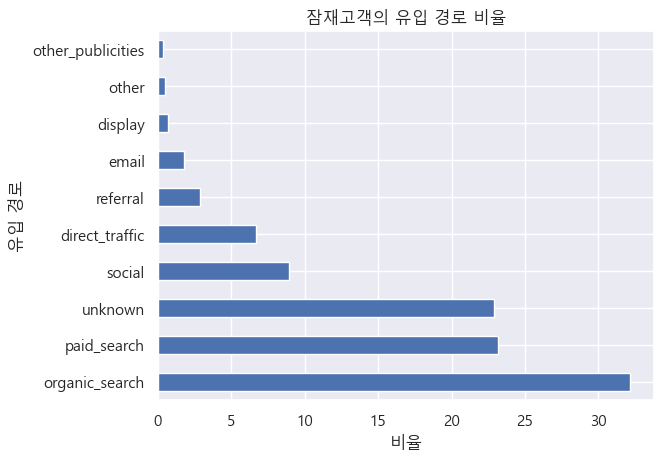

In [117]:
(mql[mql.won_date.notnull()].origin.value_counts(normalize=True)*100).plot(kind='barh')
plt.title('잠재고객의 유입 경로 비율')
plt.xlabel('비율')
plt.ylabel('유입 경로')

In [115]:
ab

,origin,mql,closed_deals,difference
0,direct_traffic,6.2375,6.650831,0.413331
1,display,1.4750,0.712589,-0.762411
2,email,6.1625,1.781473,-4.381027
3,organic_search,28.7000,32.185273,3.485273
4,other,1.8750,0.475059,-1.399941
5,other_publicities,0.8125,0.356295,-0.456205
6,paid_search,19.8250,23.159145,3.334145
7,referral,3.5500,2.850356,-0.699644
8,social,16.8750,8.907363,-7.967637
9,unknown,14.4875,22.921615,8.434115


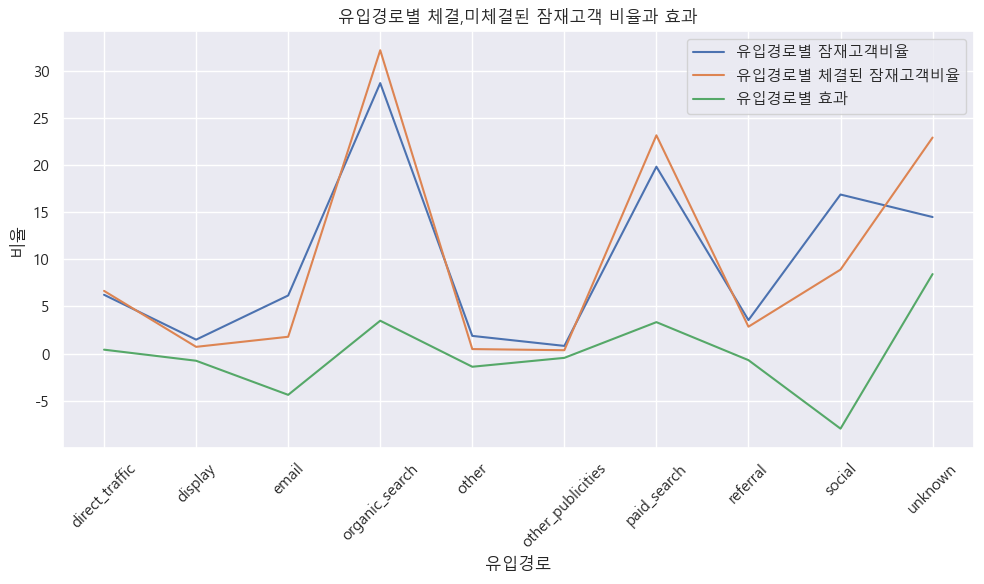

In [114]:
# 판매자별 유일경로별 전환율과 효과
a = (mql.groupby('origin').size()/mql.shape[0]*100).reset_index(name='mql')
b = (mql[mql['won_date'].notnull()]['origin'].value_counts(normalize=True)*100).reset_index(name='closed_deals')
ab = a.merge(b, on='origin')
ab['difference'] = ab['closed_deals'] - ab['mql']
ab

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 그래프 그리기
plt.plot('origin', 'mql', data=ab, label='유입경로별 잠재고객비율')
plt.plot('origin', 'closed_deals', data=ab, label='유입경로별 체결된 잠재고객비율')
plt.plot('origin', 'difference', data=ab, label='유입경로별 효과')

# x축과 y축 레이블 설정
plt.xlabel('유입경로')
plt.ylabel('비율')
plt.title('유입경로별 체결,미체결된 잠재고객 비율과 효과')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


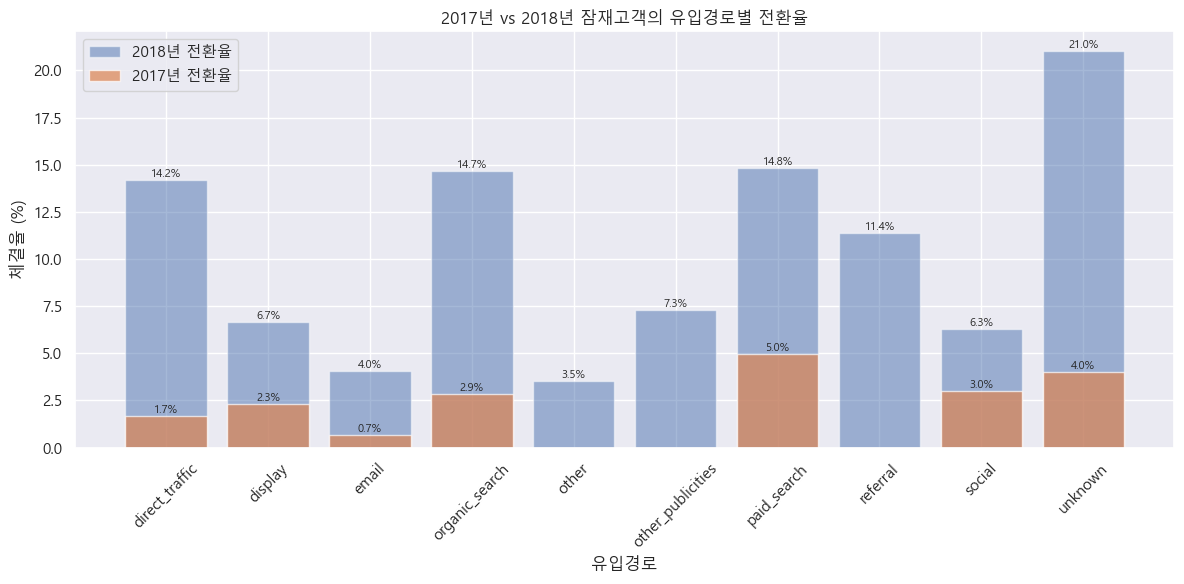

In [37]:
plt.figure(figsize=(12, 6))

# 2018년 전환율 계산 및 그래프 그리기
a_2018 = mql[(mql['won_date'].notnull()) & (mql['first_contact_date'].dt.year == 2018)].groupby('origin').size() / \
         mql[mql['first_contact_date'].dt.year == 2018].groupby('origin').size() * 100
plt.bar(a_2018.index, a_2018, alpha=0.5, label='2018년 전환율')

# 2017년 전환율 계산 및 그래프 그리기
a_2017 = mql[(mql['won_date'].notnull()) & (mql['first_contact_date'].dt.year == 2017)].groupby('origin').size() / \
         mql[mql['first_contact_date'].dt.year == 2017].groupby('origin').size() * 100
plt.bar(a_2017.index, a_2017, alpha=0.7, label='2017년 전환율')

# 그래프 안에 글씨 추가
for i, v in enumerate(a_2018):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(a_2017):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

# x축 레이블 설정
plt.xticks(rotation=45)

# x축과 y축 레이블 설정
plt.xlabel('유입경로')
plt.ylabel('체결율 (%)')

# 레전드 추가
plt.legend()

# 제목 추가
plt.title('2017년 vs 2018년 잠재고객의 유입경로별 전환율')

# 그래프 보여주기
plt.tight_layout()
plt.show()


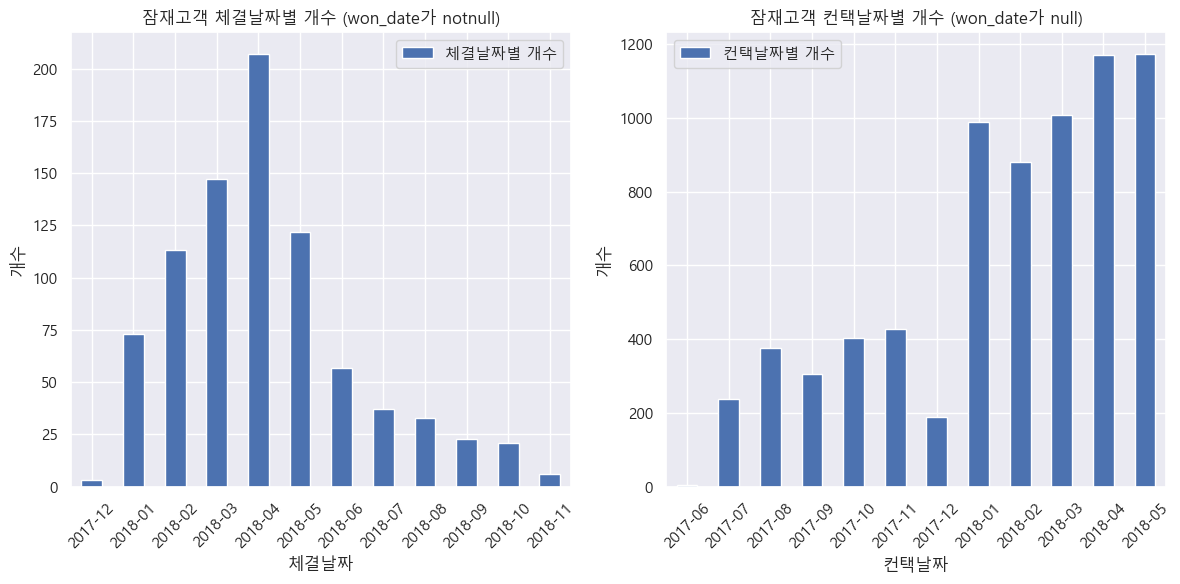

In [58]:
# 데이터프레임에서 날짜 포맷 변환
mql['won_date_new'] = pd.to_datetime(mql['won_date']).dt.strftime('%Y-%m')
mql['contact_date_new'] = pd.to_datetime(mql['first_contact_date']).dt.strftime('%Y-%m')

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 첫 번째 서브플롯: 컨택날짜별 개수 (won_date가 notnull인 경우)
plt.subplot(1, 2, 1)
ax1 = mql[mql['won_date'].notnull()].groupby('won_date_new').size().plot(kind='bar',label='체결날짜별 개수')
plt.title('잠재고객 체결날짜별 개수 (won_date가 notnull)')
plt.ylabel('개수')
plt.xlabel('체결날짜')
plt.xticks(rotation=45)
ax1.legend()

# 두 번째 서브플롯: 컨택날짜별 개수 (won_date가 null인 경우)
plt.subplot(1, 2, 2)
ax2 = mql[mql['won_date'].isnull()].groupby('contact_date_new')['origin'].count().plot(kind='bar', label='컨택날짜별 개수')
plt.title('잠재고객 컨택날짜별 개수 (won_date가 null)')
plt.ylabel('개수')
plt.xlabel('컨택날짜')
plt.xticks(rotation=45)
ax2.legend()

# 서브플롯 간 간격 조절
plt.tight_layout()

# 그래프 보여주기
plt.show()


<Axes: xlabel='sdr_id'>

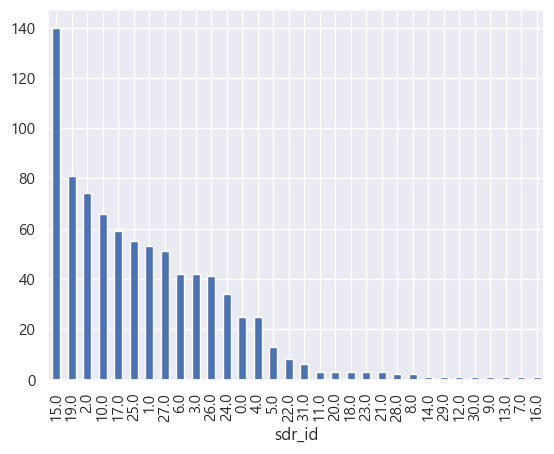

In [52]:
mql.sdr_id.value_counts().plot(kind='bar')

<Axes: xlabel='sr_id'>

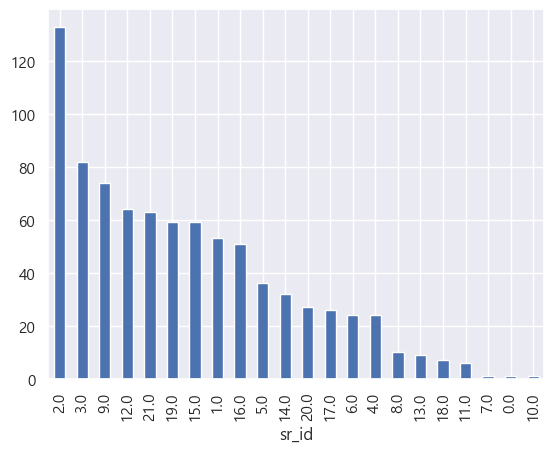

In [53]:
mql.sr_id.value_counts().plot(kind='bar')

### 비즈니스타입과 회사타입에 따른 매출과 개수파악

In [69]:
SQL = """
SELECT customer_id, customer_unique_id, customer_state
FROM customers;
"""

customers = pd.read_sql(SQL, rds_python_conn())
customers

,customer_id,customer_unique_id,customer_state
0,93596,86343,SP
1,96387,55527,SP
2,71593,44820,SP
3,17589,36016,SP
4,46972,96049,SP
...,...,...,...
99436,40421,29126,SP
99437,65930,3710,SP
99438,83443,38830,CE
99439,52687,79036,RS


In [70]:
customers.customer_id.nunique()

99441

In [66]:
SQL = """
SELECT order_id,customer_id,order_status, order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

orders = pd.read_sql(SQL, rds_python_conn())
orders

,order_id,customer_id,order_status,order_purchase_timestamp
0,13974,65773,delivered,2017-10-02 10:56:33
1,83165,13301,delivered,2018-07-24 20:41:37
2,66104,44559,delivered,2018-08-08 08:38:49
3,64037,69256,delivered,2017-11-18 19:28:06
4,14183,35294,delivered,2018-02-13 21:18:39
...,...,...,...,...
98195,63791,92532,delivered,2017-03-09 09:54:05
98196,85704,30689,delivered,2018-02-06 12:58:58
98197,19817,23177,delivered,2017-08-27 14:46:43
98198,6896,84231,delivered,2018-01-08 21:28:27


In [67]:
orders.customer_id.nunique()

98200

In [71]:
order_customer = orders.merge(customers,on='customer_id')
order_customer['order_time'] = order_customer['order_purchase_timestamp'].dt.strftime('%Y-%m')
order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,order_time
0,13974,65773,delivered,2017-10-02 10:56:33,39184,SP,2017-10
1,83165,13301,delivered,2018-07-24 20:41:37,71798,BA,2018-07
2,66104,44559,delivered,2018-08-08 08:38:49,24317,GO,2018-08
3,64037,69256,delivered,2017-11-18 19:28:06,45377,RN,2017-11
4,14183,35294,delivered,2018-02-13 21:18:39,74487,SP,2018-02
...,...,...,...,...,...,...,...
98195,63791,92532,delivered,2017-03-09 09:54:05,73555,SP,2017-03
98196,85704,30689,delivered,2018-02-06 12:58:58,5260,SP,2018-02
98197,19817,23177,delivered,2017-08-27 14:46:43,63257,BA,2017-08
98198,6896,84231,delivered,2018-01-08 21:28:27,82042,RJ,2018-01


In [ ]:
---------------------------------------------------

In [74]:
SQL = """
SELECT order_id, review_score, review_comment_message
FROM reviews
"""

reviews = pd.read_sql(SQL, rds_python_conn())
reviews

,order_id,review_score,review_comment_message
0,64002,4,None
1,78339,5,None
2,25907,5,None
3,80635,5,Recebi bem antes do prazo estipulado.
4,72488,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99219,96979,5,None
99220,9999,5,None
99221,67181,5,"Excelente mochila, entrega super rápida. Super..."
99222,81384,4,None


In [75]:
SQL = """
SELECT order_id,order_status
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

order = pd.read_sql(SQL, rds_python_conn())
order

,order_id,order_status
0,13974,delivered
1,83165,delivered
2,66104,delivered
3,64037,delivered
4,14183,delivered
...,...,...
98195,63791,delivered
98196,85704,delivered
98197,19817,delivered
98198,6896,delivered


In [79]:
revi = order.merge(reviews,on='order_id',how='left')
revi

,order_id,order_status,review_score,review_comment_message
0,13974,delivered,4.0,"Não testei o produto ainda, mas ele veio corre..."
1,83165,delivered,4.0,Muito bom o produto.
2,66104,delivered,5.0,None
3,64037,delivered,5.0,O produto foi exatamente o que eu esperava e e...
4,14183,delivered,5.0,None
...,...,...,...,...
98740,63791,delivered,5.0,None
98741,85704,delivered,4.0,So uma peça que veio rachado mas tudo bem rs
98742,19817,delivered,5.0,Foi entregue antes do prazo.
98743,6896,delivered,2.0,Foi entregue somente 1. Quero saber do outro p...


In [88]:
(revi.review_score.value_counts(normalize=True)*100)

review_score
5.0    58.382051
4.0    19.482110
1.0    10.749594
3.0     8.260129
2.0     3.126116
Name: proportion, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '5.0'),
  Text(1, 0, '4.0'),
  Text(2, 0, '1.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '2.0')])

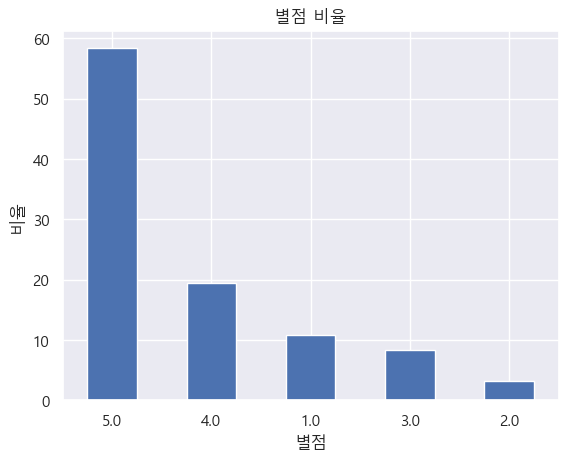

In [87]:
(revi.review_score.value_counts(normalize=True)*100).plot.bar()
plt.title('별점 비율')
plt.ylabel('비율')
plt.xlabel('별점')
plt.xticks(rotation=0)

In [124]:
# revi_ =revi[revi['review_comment_message'].notnull()]
revi_.shape

(40154, 5)

In [131]:
def google_apt(review):
    import googletrans

    translator = googletrans.Translator()
    result1 = translator.translate(str1, dest='en')

    return result1.text
revi_['new_review_english'] = revi_['review_comment_message'].apply(lambda x: google_apt(x))

KeyboardInterrupt: 

In [ ]:
from nltk.tokenize.regexp import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tokenizer = RegexpTokenizer("[\w']+")
new_data2 = tokenizer.tokenizer(data1)
data4 = [each_word for each_word in new_data3 if each_word not in stopwords.words()]
data5 = Counter(data4)
data6 = data5.most_common(100)
data7 = dict(data6)

wordcloud = WordCloud(relative_scaling = 0.2, background_color = 'black').generate_from_frequencies(data7)
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('on')
plt.show()

In [82]:
SQL = """
SELECT *
FROM mql;
"""

mql_c = pd.read_sql(SQL, rds_python_conn())
mql_c

,mql_id,first_contact_date,landing_page_id,origin
0,5143,2018-02-01,490,social
1,5819,2017-10-20,247,paid_search
2,1369,2018-03-22,95,organic_search
3,312,2018-01-22,435,email
4,3690,2018-02-21,119,organic_search
...,...,...,...,...
7995,2920,2018-05-22,300,paid_search
7996,3895,2018-03-27,269,paid_search
7997,7527,2017-08-27,119,organic_search
7998,639,2017-10-06,489,organic_search


In [80]:
SQL = """
SELECT *
FROM closed_deals;
"""

closed_deals = pd.read_sql(SQL, rds_python_conn())
closed_deals

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue
0,3690,2187,17,2,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0
1,6059,648,6,3,2018-05-08 20:17:59,car_accessories,industry,eagle,reseller,0.0
2,1076,3397,0,9,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,0.0
3,221,1900,2,3,2018-01-17 13:51:03,food_drink,online_small,unknown,reseller,0.0
4,1265,3242,15,3,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,0.0
...,...,...,...,...,...,...,...,...,...,...
837,598,2629,22,17,2018-08-01 20:22:31,home_decor,offline,cat,reseller,0.0
838,1527,1235,27,13,2018-09-27 18:58:41,construction_tools_house_garden,online_big,wolf,reseller,200000.0
839,7113,3301,27,17,2018-06-06 20:15:26,computers,online_medium,wolf,reseller,0.0
840,5228,1289,19,3,2018-03-06 15:52:23,pet,online_beginner,cat,reseller,0.0


In [83]:
df = mql_c.merge(closed_deals, on='mql_id')
df

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue
0,3690,2018-02-21,119,organic_search,2187,17,2,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0
1,6059,2018-04-04,39,referral,648,6,3,2018-05-08 20:17:59,car_accessories,industry,eagle,reseller,0.0
2,1076,2018-04-03,417,organic_search,3397,0,9,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,0.0
3,221,2018-01-14,196,paid_search,1900,2,3,2018-01-17 13:51:03,food_drink,online_small,unknown,reseller,0.0
4,1265,2017-10-09,432,unknown,3242,15,3,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,598,2018-03-28,95,organic_search,2629,22,17,2018-08-01 20:22:31,home_decor,offline,cat,reseller,0.0
838,1527,2018-05-18,382,organic_search,1235,27,13,2018-09-27 18:58:41,construction_tools_house_garden,online_big,wolf,reseller,200000.0
839,7113,2018-05-25,358,paid_search,3301,27,17,2018-06-06 20:15:26,computers,online_medium,wolf,reseller,0.0
840,5228,2018-02-04,490,social,1289,19,3,2018-03-06 15:52:23,pet,online_beginner,cat,reseller,0.0


In [66]:
a=df.groupby('seller_id')['declared_monthly_revenue'].sum().reset_index()
a

,seller_id,declared_monthly_revenue
0,11,0.0
1,13,100000.0
2,14,0.0
3,20,0.0
4,21,0.0
...,...,...
837,3540,0.0
838,3541,0.0
839,3544,0.0
840,3548,0.0


In [84]:
SQL = """
SELECT order_id,order_item_id, product_id, seller_id, price, freight_value
FROM "order_items"
"""

order_items = pd.read_sql(SQL, rds_python_conn())
order_items

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,96870,1,12130,2622,58.90,13.29
1,9433,1,29611,1942,239.90,19.93
2,87326,1,23255,1180,199.00,17.87
3,91182,1,1404,620,12.99,12.79
4,79789,1,30255,2293,199.90,18.14
...,...,...,...,...,...,...
112645,59834,1,32313,3029,299.99,43.41
112646,72009,1,25525,1470,350.00,36.53
112647,56253,1,159,3059,99.90,16.95
112648,89718,1,11543,1506,55.99,8.72


In [121]:
SQL = """
SELECT product_id,product_category_name
FROM products
"""

product = pd.read_sql(SQL, rds_python_conn())
product

,product_id,product_category_name
0,16234,perfumery
1,6621,art
2,22240,sports_leisure
3,18578,baby
4,14617,housewares
...,...,...
32946,28216,furniture_decor
32947,20353,construction_tools_lights
32948,3826,bed_bath_table
32949,29140,computers_accessories


In [124]:
orders_pro = order_items.merge(product,on='product_id',how='left')
orders_pro

,order_id,order_item_id,product_id,seller_id,price,freight_value,product_category_name
0,96870,1,12130,2622,58.90,13.29,cool_stuff
1,9433,1,29611,1942,239.90,19.93,pet_shop
2,87326,1,23255,1180,199.00,17.87,furniture_decor
3,91182,1,1404,620,12.99,12.79,perfumery
4,79789,1,30255,2293,199.90,18.14,garden_tools
...,...,...,...,...,...,...,...
112645,59834,1,32313,3029,299.99,43.41,housewares
112646,72009,1,25525,1470,350.00,36.53,computers_accessories
112647,56253,1,159,3059,99.90,16.95,sports_leisure
112648,89718,1,11543,1506,55.99,8.72,computers_accessories


In [129]:
SQL = """
SELECT order_id, customer_id, order_status, order_purchase_timestamp
FROM "order"
WHERE order_status in ('delivered','shipped','invoiced','processing')
"""

orders = pd.read_sql(SQL, rds_python_conn())
orders

,order_id,customer_id,order_status,order_purchase_timestamp
0,13974,65773,delivered,2017-10-02 10:56:33
1,83165,13301,delivered,2018-07-24 20:41:37
2,66104,44559,delivered,2018-08-08 08:38:49
3,64037,69256,delivered,2017-11-18 19:28:06
4,14183,35294,delivered,2018-02-13 21:18:39
...,...,...,...,...
98195,63791,92532,delivered,2017-03-09 09:54:05
98196,85704,30689,delivered,2018-02-06 12:58:58
98197,19817,23177,delivered,2017-08-27 14:46:43
98198,6896,84231,delivered,2018-01-08 21:28:27


In [126]:
orders.order_id.nunique()

98200

In [136]:
tmp = orders.merge(orders_pro,on='order_id',how='left')
tmp['sum'] = tmp['price']+tmp['freight_value']
tmp

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,product_category_name,sum
0,13974,65773,delivered,2017-10-02 10:56:33,1.0,19486.0,2940.0,29.99,8.72,housewares,38.71
1,83165,13301,delivered,2018-07-24 20:41:37,1.0,16644.0,3268.0,118.70,22.76,perfumery,141.46
2,66104,44559,delivered,2018-08-08 08:38:49,1.0,28208.0,1712.0,159.90,19.22,auto,179.12
3,64037,69256,delivered,2017-11-18 19:28:06,1.0,27380.0,91.0,45.00,27.20,pet_shop,72.20
4,14183,35294,delivered,2018-02-13 21:18:39,1.0,31317.0,3165.0,19.90,8.72,stationery,28.62
...,...,...,...,...,...,...,...,...,...,...,...
112096,85704,30689,delivered,2018-02-06 12:58:58,1.0,8698.0,1444.0,174.90,20.10,baby,195.00
112097,19817,23177,delivered,2017-08-27 14:46:43,1.0,7151.0,2752.0,205.99,65.02,home_appliances_2,271.01
112098,6896,84231,delivered,2018-01-08 21:28:27,1.0,26886.0,3522.0,179.99,40.59,computers_accessories,220.58
112099,6896,84231,delivered,2018-01-08 21:28:27,2.0,26886.0,3522.0,179.99,40.59,computers_accessories,220.58


In [133]:
tmp.order_id.nunique()

98200

In [56]:
SQL = """
SELECT lead_type,sum(declared_monthly_revenue), count(declared_monthly_revenue)
FROM mql m join closed_deals j on m.mql_id=j.mql_id
group by lead_type
order by 2;
"""

rows = sql(SQL)
mql = pd.DataFrame(rows)
print('회사타입별 매출합계, 개수')
mql

회사타입별 매출합계, 개수


,0,1,2
0,online_top,0.0,14
1,online_beginner,1006.0,57
2,offline,280000.0,104
3,online_medium,582000.0,338
4,other,626000.0,3
5,online_small,730000.0,77
6,online_big,9060000.0,126
7,industry,50505000.0,123


In [58]:
SQL = """
SELECT business_type,lead_type,count(lead_type)
FROM mql m join closed_deals j on m.mql_id=j.mql_id
group by business_type,lead_type
order by 1,2,3;
"""

rows = sql(SQL)
mql = pd.DataFrame(rows)
print('비즈니스분야, 회사타입별 개수')
mql

비즈니스분야, 회사타입별 개수


,0,1,2
0,manufacturer,industry,69
1,manufacturer,offline,21
2,manufacturer,online_beginner,18
3,manufacturer,online_big,23
4,manufacturer,online_medium,79
5,manufacturer,online_small,28
6,manufacturer,online_top,4
7,other,other,3
8,reseller,industry,54
9,reseller,offline,83


회사 성격별 개수와 매출합계


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'cat'),
  Text(1, 0, 'unknown'),
  Text(2, 0, 'eagle'),
  Text(3, 0, 'wolf'),
  Text(4, 0, 'shark'),
  Text(5, 0, 'cat, wolf'),
  Text(6, 0, 'eagle, wolf'),
  Text(7, 0, 'eagle, cat'),
  Text(8, 0, 'shark, wolf'),
  Text(9, 0, 'shark, cat')])

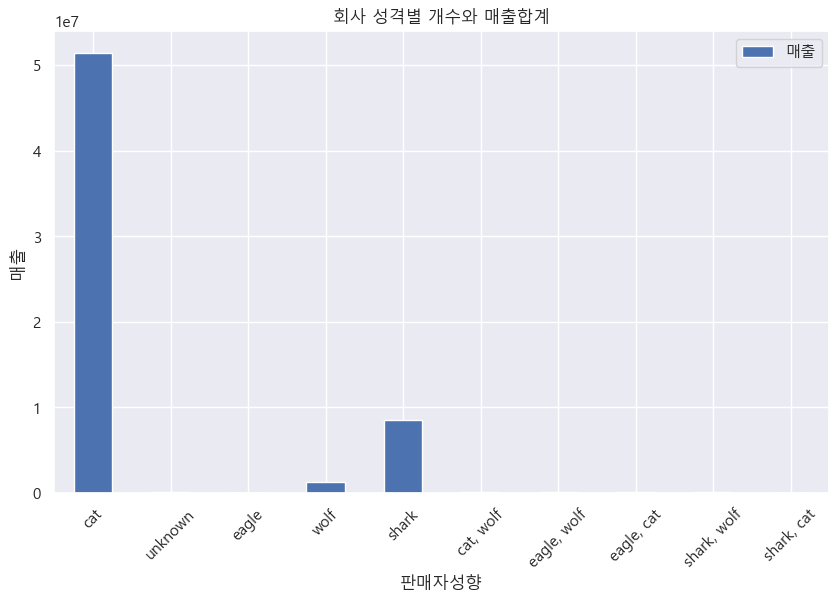

In [65]:
SQL = """
SELECT lead_behaviour_profile,count(lead_behaviour_profile) as 판매자성향,
        sum(declared_monthly_revenue) as 매출
FROM mql m join closed_deals j on m.mql_id=j.mql_id
group by lead_behaviour_profile
order by 2 desc;
"""


mql = pd.read_sql(SQL, rds_python_conn())
print('회사 성격별 개수와 매출합계')
mql.plot(x='lead_behaviour_profile', y='매출', kind='bar', figsize=(10, 6))
plt.title('회사 성격별 개수와 매출합계')
plt.xlabel('판매자성향')
plt.ylabel('매출')
plt.xticks(rotation=45)


In [103]:
SQL = """
SELECT business_segment,business_type,count(business_segment)
FROM mql m join closed_deals j on m.mql_id=j.mql_id
group by business_segment, business_type
order by 1,3 desc;
"""

rows = sql(SQL)
mql = pd.DataFrame(rows)
print('회사 사업 분야, 비즈니스타입별 개수')
mql

회사 사업 분야, 비즈니스타입별 개수


,0,1,2
0,air_conditioning,reseller,3
1,audio_video_electronics,reseller,58
2,audio_video_electronics,manufacturer,6
3,baby,reseller,6
4,baby,manufacturer,4
5,bags_backpacks,reseller,12
6,bags_backpacks,manufacturer,10
7,bed_bath_table,reseller,15
8,bed_bath_table,manufacturer,7
9,books,reseller,6


### 매출파악(구매자 결제건)

In [39]:
# ('delivered','shipped','invoiced','processing') 이경우만 가지고 파악.
SQL = """
SELECT *
FROM "order"
WHERE order_status in ('delivered','shipped','invoiced','processing') and order_purchase_timestamp < '2018-09-01'
order by order_id
"""


order = pd.read_sql(SQL, rds_python_conn())
order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,10071,delivered,2017-02-13 16:12:43,2017-02-13 16:25:09,2017-02-14 10:58:44,2017-03-01 11:16:06,2017-03-24
1,1,36159,delivered,2018-01-07 21:13:42,2018-01-07 21:27:12,2018-01-10 18:36:40,2018-01-15 20:10:13,2018-01-31
2,2,23371,delivered,2018-08-23 13:56:50,2018-08-23 14:10:15,2018-08-23 15:42:00,2018-08-27 18:32:55,2018-09-04
3,3,31171,delivered,2017-12-12 08:39:09,2017-12-12 10:32:39,2017-12-13 18:38:53,2017-12-18 20:09:12,2018-01-11
4,4,53810,delivered,2017-11-08 15:02:42,2017-11-09 15:11:00,2017-11-16 19:34:27,2017-11-21 12:52:26,2017-11-22
...,...,...,...,...,...,...,...,...
98194,99436,27340,delivered,2018-05-08 19:42:13,2018-05-08 20:31:59,2018-05-09 12:39:00,2018-05-16 23:38:52,2018-05-22
98195,99437,87752,delivered,2017-07-05 11:56:09,2017-07-05 17:43:11,2017-07-11 16:34:32,2017-07-19 20:34:51,2017-08-04
98196,99438,92997,delivered,2017-07-05 18:06:31,2017-07-05 18:23:31,2017-07-07 13:49:57,2017-07-10 19:15:30,2017-07-21
98197,99439,97562,delivered,2017-10-27 12:07:08,2017-10-27 12:28:41,2017-10-30 13:21:46,2017-11-14 17:47:07,2017-11-21


In [40]:
SQL = """
SELECT customer_id, customer_unique_id
FROM customers
"""


uniqueid = pd.read_sql(SQL, rds_python_conn())
uniqueid

,customer_id,customer_unique_id
0,93596,86343
1,96387,55527
2,71593,44820
3,17589,36016
4,46972,96049
...,...,...
99436,40421,29126
99437,65930,3710
99438,83443,38830
99439,52687,79036


In [41]:
uniqueid.nunique()

customer_id           99441
customer_unique_id    96096
dtype: int64

In [42]:
order_uniqueid = order.merge(uniqueid,on='customer_id',how='left')
order_uniqueid

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,0,10071,delivered,2017-02-13 16:12:43,2017-02-13 16:25:09,2017-02-14 10:58:44,2017-03-01 11:16:06,2017-03-24,21081
1,1,36159,delivered,2018-01-07 21:13:42,2018-01-07 21:27:12,2018-01-10 18:36:40,2018-01-15 20:10:13,2018-01-31,9745
2,2,23371,delivered,2018-08-23 13:56:50,2018-08-23 14:10:15,2018-08-23 15:42:00,2018-08-27 18:32:55,2018-09-04,53790
3,3,31171,delivered,2017-12-12 08:39:09,2017-12-12 10:32:39,2017-12-13 18:38:53,2017-12-18 20:09:12,2018-01-11,60982
4,4,53810,delivered,2017-11-08 15:02:42,2017-11-09 15:11:00,2017-11-16 19:34:27,2017-11-21 12:52:26,2017-11-22,77280
...,...,...,...,...,...,...,...,...,...
98194,99436,27340,delivered,2018-05-08 19:42:13,2018-05-08 20:31:59,2018-05-09 12:39:00,2018-05-16 23:38:52,2018-05-22,84335
98195,99437,87752,delivered,2017-07-05 11:56:09,2017-07-05 17:43:11,2017-07-11 16:34:32,2017-07-19 20:34:51,2017-08-04,33367
98196,99438,92997,delivered,2017-07-05 18:06:31,2017-07-05 18:23:31,2017-07-07 13:49:57,2017-07-10 19:15:30,2017-07-21,48993
98197,99439,97562,delivered,2017-10-27 12:07:08,2017-10-27 12:28:41,2017-10-30 13:21:46,2017-11-14 17:47:07,2017-11-21,69845


In [116]:
# ('delivered','shipped','invoiced','processing') 이경우만 가지고 파악.
SQL = """
SELECT *
FROM "order" o join payments p on o.order_id=p.order_Id 
WHERE order_status in ('delivered','shipped','invoiced','processing') 
order by o.order_id
"""


orderpayment = pd.read_sql(SQL, rds_python_conn())
orderpayment = orderpayment.loc[:, ~orderpayment.columns.duplicated()]
orderpayment

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,0,10071,delivered,2017-02-13 16:12:43,2017-02-13 16:25:09,2017-02-14 10:58:44,2017-03-01 11:16:06,2017-03-24,1,credit_card,2,104.87
1,1,36159,delivered,2018-01-07 21:13:42,2018-01-07 21:27:12,2018-01-10 18:36:40,2018-01-15 20:10:13,2018-01-31,1,credit_card,3,126.54
2,2,23371,delivered,2018-08-23 13:56:50,2018-08-23 14:10:15,2018-08-23 15:42:00,2018-08-27 18:32:55,2018-09-04,1,credit_card,8,279.11
3,3,31171,delivered,2017-12-12 08:39:09,2017-12-12 10:32:39,2017-12-13 18:38:53,2017-12-18 20:09:12,2018-01-11,1,credit_card,7,73.64
4,4,53810,delivered,2017-11-08 15:02:42,2017-11-09 15:11:00,2017-11-16 19:34:27,2017-11-21 12:52:26,2017-11-22,1,credit_card,2,24.68
...,...,...,...,...,...,...,...,...,...,...,...,...
102561,99436,27340,delivered,2018-05-08 19:42:13,2018-05-08 20:31:59,2018-05-09 12:39:00,2018-05-16 23:38:52,2018-05-22,1,credit_card,10,1057.88
102562,99437,87752,delivered,2017-07-05 11:56:09,2017-07-05 17:43:11,2017-07-11 16:34:32,2017-07-19 20:34:51,2017-08-04,1,credit_card,1,264.66
102563,99438,92997,delivered,2017-07-05 18:06:31,2017-07-05 18:23:31,2017-07-07 13:49:57,2017-07-10 19:15:30,2017-07-21,1,credit_card,1,27.77
102564,99439,97562,delivered,2017-10-27 12:07:08,2017-10-27 12:28:41,2017-10-30 13:21:46,2017-11-14 17:47:07,2017-11-21,1,credit_card,1,61.05


In [117]:
# 객단가
# 가설 1 : 매출이 감소한건 객단가가 감소했기 때문이다.
# 전체기간기준
print(orderpayment['payment_value'].sum())
orderpayment['payment_value'].sum()/orderpayment.shape[0]

15738207.83


153.44468761577912

In [120]:
orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['payment_value'].sum()

order_purchase_timestamp
2016-09        136.23
2016-10      51657.53
2016-12         19.62
2017-01     137006.76
2017-02     283560.32
2017-03     425656.40
2017-04     405808.92
2017-05     582926.16
2017-06     499827.47
2017-07     578858.58
2017-08     662071.77
2017-09     717195.22
2017-10     764785.28
2017-11    1172355.54
2017-12     861647.65
2018-01    1102639.41
2018-02     979828.63
2018-03    1152736.74
2018-04    1156303.91
2018-05    1145748.63
2018-06    1020494.29
2018-07    1039880.16
2018-08     996896.15
2018-09        166.46
Name: payment_value, dtype: float64

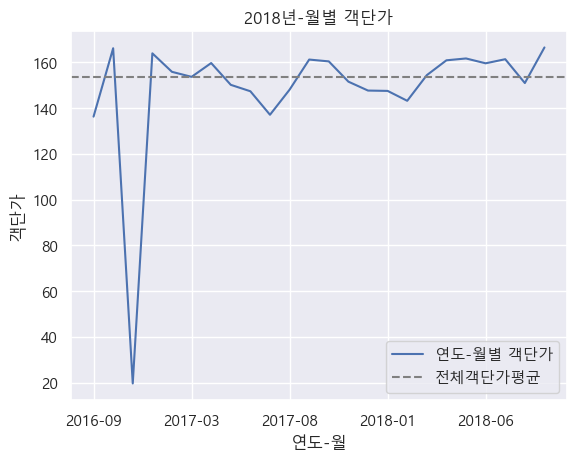

In [122]:
(orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['payment_value'].sum()/orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['order_id'].size()).plot(label='연도-월별 객단가')
plt.axhline(y=orderpayment['payment_value'].sum()/orderpayment.shape[0], color='gray', linestyle='--', label='전체객단가평균')
plt.title('2018년-월별 객단가')
plt.xlabel('연도-월')
plt.ylabel('객단가')

plt.legend()


In [121]:
orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['order_id'].size()

order_purchase_timestamp
2016-09       1
2016-10     311
2016-12       1
2017-01     836
2017-02    1820
2017-03    2771
2017-04    2542
2017-05    3883
2017-06    3393
2017-07    4224
2017-08    4473
2017-09    4450
2017-10    4769
2017-11    7738
2017-12    5837
2018-01    7477
2018-02    6845
2018-03    7468
2018-04    7189
2018-05    7088
2018-06    6397
2018-07    6446
2018-08    6606
2018-09       1
Name: order_id, dtype: int64

In [124]:
orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['payment_value'].sum()

order_purchase_timestamp
2016-09        136.23
2016-10      51657.53
2016-12         19.62
2017-01     137006.76
2017-02     283560.32
2017-03     425656.40
2017-04     405808.92
2017-05     582926.16
2017-06     499827.47
2017-07     578858.58
2017-08     662071.77
2017-09     717195.22
2017-10     764785.28
2017-11    1172355.54
2017-12     861647.65
2018-01    1102639.41
2018-02     979828.63
2018-03    1152736.74
2018-04    1156303.91
2018-05    1145748.63
2018-06    1020494.29
2018-07    1039880.16
2018-08     996896.15
2018-09        166.46
Name: payment_value, dtype: float64

Text(0, 0.5, '주문 건수')

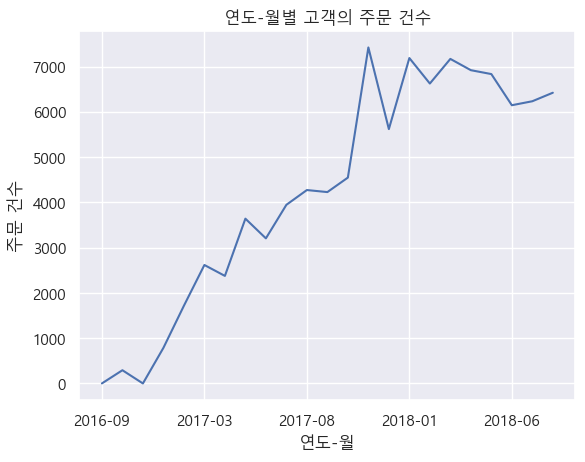

In [68]:
order_uniqueid.groupby(pd.to_datetime(order_uniqueid['order_purchase_timestamp']).dt.strftime('%Y-%m'))['customer_unique_id'].size().plot()
plt.title('연도-월별 고객의 주문 건수')
plt.xlabel('연도-월')
plt.ylabel('주문 건수')

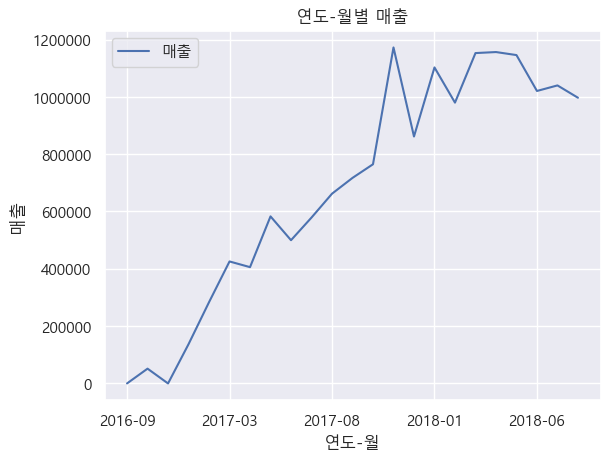

In [69]:
orderpayment.groupby(pd.to_datetime(orderpayment['order_purchase_timestamp']).dt.strftime('%Y-%m'))['payment_value'].sum().plot(label='매출')
plt.title('연도-월별 매출')
plt.xlabel('연도-월')
plt.ylabel('매출')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

# 2017년 11월에 최고점(1172355.54)을 찍고 그 후 상승과 하락을 반복.2018년 4월에서 8월까지는 계속 매출하락.

In [77]:
SQL = """
SELECT *
FROM "order" o join payments p on o.order_id=p.order_Id 
WHERE order_status in ('delivered','shipped','invoiced','processing') and order_purchase_timestamp < '2018-09-01'
order by o.order_id
"""


orderpayment = pd.read_sql(SQL, rds_python_conn())
orderpayment

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,10071,delivered,2017-02-13 16:12:43,2017-02-13 16:25:09,2017-02-14 10:58:44,2017-03-01 11:16:06,2017-03-24,0,1,credit_card,2,104.87
1,1,36159,delivered,2018-01-07 21:13:42,2018-01-07 21:27:12,2018-01-10 18:36:40,2018-01-15 20:10:13,2018-01-31,1,1,credit_card,3,126.54
2,2,23371,delivered,2018-08-23 13:56:50,2018-08-23 14:10:15,2018-08-23 15:42:00,2018-08-27 18:32:55,2018-09-04,2,1,credit_card,8,279.11
3,3,31171,delivered,2017-12-12 08:39:09,2017-12-12 10:32:39,2017-12-13 18:38:53,2017-12-18 20:09:12,2018-01-11,3,1,credit_card,7,73.64
4,4,53810,delivered,2017-11-08 15:02:42,2017-11-09 15:11:00,2017-11-16 19:34:27,2017-11-21 12:52:26,2017-11-22,4,1,credit_card,2,24.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102560,99436,27340,delivered,2018-05-08 19:42:13,2018-05-08 20:31:59,2018-05-09 12:39:00,2018-05-16 23:38:52,2018-05-22,99436,1,credit_card,10,1057.88
102561,99437,87752,delivered,2017-07-05 11:56:09,2017-07-05 17:43:11,2017-07-11 16:34:32,2017-07-19 20:34:51,2017-08-04,99437,1,credit_card,1,264.66
102562,99438,92997,delivered,2017-07-05 18:06:31,2017-07-05 18:23:31,2017-07-07 13:49:57,2017-07-10 19:15:30,2017-07-21,99438,1,credit_card,1,27.77
102563,99439,97562,delivered,2017-10-27 12:07:08,2017-10-27 12:28:41,2017-10-30 13:21:46,2017-11-14 17:47:07,2017-11-21,99439,1,credit_card,1,61.05


In [101]:
SQL = """
SELECT *
FROM customers
"""
SQL2 = """
SELECT *
FROM order_items
"""
SQL3 = """
SELECT *
FROM products
"""
SQL4 = """
SELECT *
FROM "order"
"""
df_customers = pd.read_sql(SQL, rds_python_conn())
df_order_items = pd.read_sql(SQL2, rds_python_conn())
df_products = pd.read_sql(SQL3, rds_python_conn())
df_order = pd.read_sql(SQL4, rds_python_conn())


In [107]:
# 주문<> 고객 머지
merged_data = df_order.merge(df_customers, on='customer_id', how='left')

# order_items 머지
merged_data = merged_data.merge(df_order_items, on='order_id', how='left')

# product 머지
merged_data = merged_data.merge(df_products, on='product_id', how='left')

# 각 고객이 해당 카테고리에서 몇 번 구매했는지
customer_category_count = merged_data.groupby(['customer_unique_id', 'product_category_name']).size().reset_index(name='purchase_count')

# 각 카테고리에서 두 번 이상 구매한 고객 수 
repeat_customers = customer_category_count[customer_category_count['purchase_count'] > 1].groupby('product_category_name').size()

# 각 카테고리에서의 전체 구매 고객 수
total_customers = customer_category_count.groupby('product_category_name').size()

# 재구매율
repurchase_rate = (repeat_customers / total_customers * 100).reset_index(name='repurchase_rate').sort_values(by='repurchase_rate', ascending=False)

print(repurchase_rate.head(10))
print('-----------------------------------------------')
print(repurchase_rate.tail(10))

       product_category_name  repurchase_rate
46            home_comfort_2        26.086957
62    signaling_and_security        24.460432
39           furniture_decor        20.531898
21  costruction_tools_garden        19.895288
57          office_furniture        18.354430
38         furniture_bedroom        17.582418
11         cds_dvds_musicals        16.666667
30     fashion_male_clothing        16.363636
42              garden_tools        16.021783
7             bed_bath_table        15.768179
-----------------------------------------------
                    product_category_name  repurchase_rate
32                          fashion_sport         3.703704
20                             cool_stuff         3.623790
45                      home_appliances_2         3.056769
10                        books_technical         2.702703
2                                     art         1.485149
64  small_appliances_home_oven_and_coffee         1.333333
29              fashion_childrens

In [127]:
query = """
        SELECT customer_unique_id, 
               MAX(DATE(order_purchase_timestamp)) AS R,
               COUNT(DISTINCT a.order_id) AS F,
               SUM(payment_value) AS M
        FROM  "orders" AS a
        LEFT 
        JOIN   order_payments AS b  
        ON     a.order_id = b.order_id
        LEFT
        JOIN   customers AS c
        ON     a.customer_id = c.customer_id
        WHERE  order_status in ('delivered','shipped','invoiced','processing') and order_purchase_timestamp < '2018-09-01'
        GROUP
        BY     customer_unique_id
        ORDER
        BY     M DESC
        """

rfm_data = pd.read_sql(query, rds_python_conn())
rfm_data

DatabaseError: Execution failed on sql '
        SELECT customer_unique_id, 
               MAX(DATE(order_purchase_timestamp)) AS R,
               COUNT(DISTINCT a.order_id) AS F,
               SUM(payment_value) AS M
        FROM  "order" AS a
        LEFT 
        JOIN   order_payments AS b  
        ON     a.order_id = b.order_id
        LEFT
        JOIN   customers AS c
        ON     a.customer_id = c.customer_id
        WHERE  order_status in ('delivered','shipped','invoiced','processing') and order_purchase_timestamp < '2018-09-01'
        GROUP
        BY     customer_unique_id
        ORDER
        BY     M DESC
        ': relation "order_payments" does not exist
LINE 8:         JOIN   order_payments AS b  
                       ^
